**합성곱 신경망을 사용한 컴퓨터 비전**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import os
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

흑백 이미지와 컬러 이미지 출력을 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')


def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

# 합성곱이란 무엇인가?

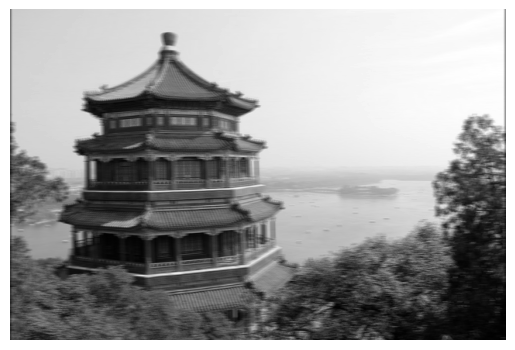

In [3]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf

# 샘플 이미지를 로드한다.
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# 2개의 필터를 만든다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
plt.imshow(outputs[0, :, :, 1], cmap='gray')  # 첫 번째 이미지의 두 번째 특성맵을 그린다.
plt.axis('off')
plt.show()

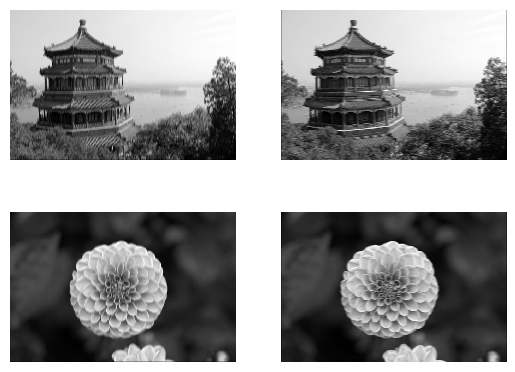

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


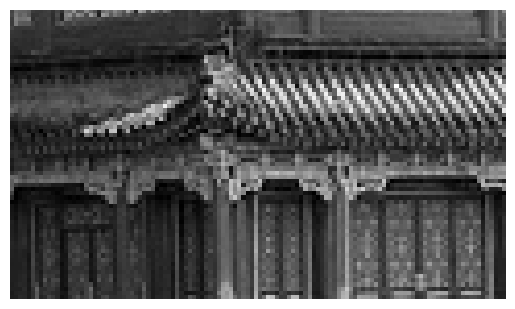

그림 저장 china_vertical


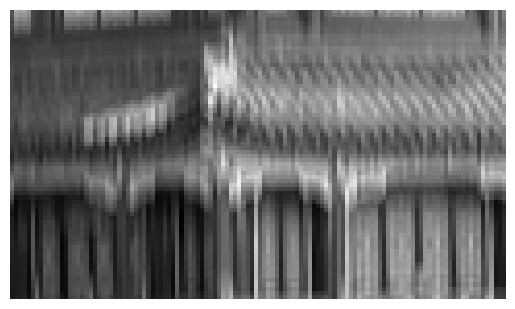

그림 저장 china_horizontal


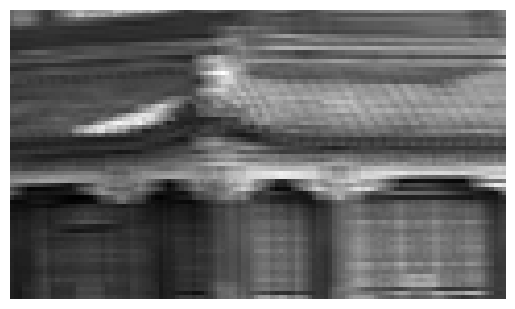

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig('china_original', tight_layout=False)
plt.show()
for feature_map_index, filename in enumerate(['china_vertical', 'china_horizontal']):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

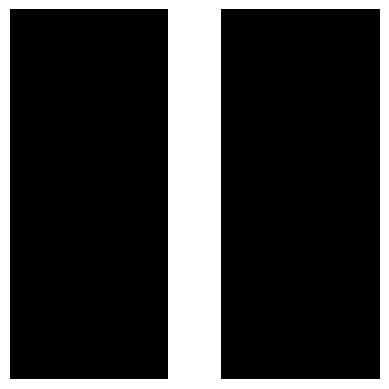

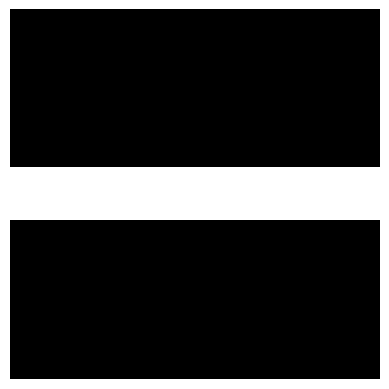

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## 합성곱 층

`keras.layers.Conv2D()`를 사용해 2D 합성곱 층을 만들어 본다:

In [8]:
from tensorflow import keras

conv = keras.layers.Conv2D(
    filters=2, kernel_size=7, strides=1, padding='SAME', activation='relu', input_shape=outputs.shape
)

두 개의 테스트 이미지로 이 층을 호출한다:

In [9]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

출력은 4D 텐서이다. 차원은 배치 크기, 높이, 너비, 채널이다. 2개의 이미지를 입력으로 사용했기 때문에 첫 번째 차원(배치 크기)는 2이다. 다음 두 차원은 출력 특성맵의 높이와 너비이다. `padding='SAME'`와 `strides=1`로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 같다(이 경우 427×640). 마지막으로 이 합성곱 층은 2개의 필터를 사용한다. 따라서 마지막 차원의 크기는 2이다. 즉 입력 이미지마다 2개의 특성맵이 출력된다.

필터는 초기에 랜덤하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지한다. 이미지마다 출력된 2개의 특성맵을 확인해 본다:

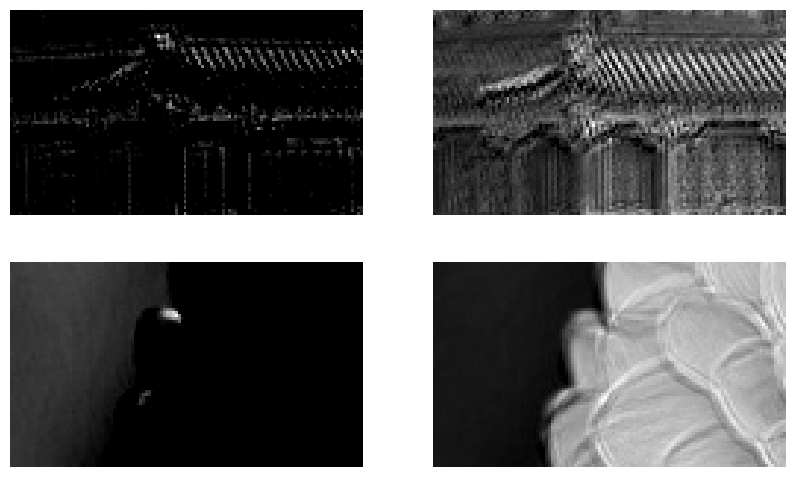

In [10]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

원한다면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 있다(합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습하기 때문에 실제로는 수동으로 필터와 편향을 지정할 필요가 거의 없다):

In [11]:
conv.set_weights([filters, np.zeros(2)])

이제 이 층을 동일한 두 이미지에서 다시 호출해 본다. 그다음 출력 특성맵이 (앞에서처럼) 수직선과 수평선을 부각하는지 확인해 보겠다:

In [12]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

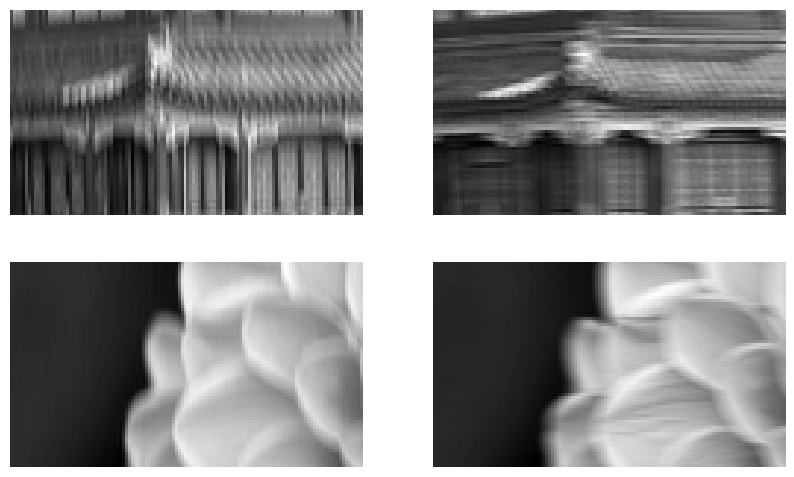

In [13]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME 패딩

In [41]:
def feature_map_size(input_size, kernel_size, strides=1, padding='SAME'):
    if padding == 'SAME':
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [42]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [43]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height + top_pad, left_pad:width + left_pad, :] = images
    return padded_images

`'SAME'` 패딩을 사용하는 것은 `manual_same_padding()`을 사용해 수동으로 패딩하고 `'VALID'` 패딩을 사용하는 것과 동일하다(혼동될 수 있지만 `'VALID'` 패딩은 전혀 패딩을 하지 않는다는 뜻이다):

In [44]:
kernel_size = 7
strides = 2
conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='VALID')
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='SAME')
valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))
# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 한다.
conv_same.build(tf.TensorShape(images.shape))
# conv_valid의 가중치를 conv_same으로 복사한다.
conv_same.set_weights(conv_valid.get_weights())
same_output = conv_same(images.astype(np.float32))
assert np.allclose(valid_output.numpy(), same_output.numpy())

# 풀링 층